In [176]:
import glob
import json
import logging
import os
from collections import defaultdict
from io import TextIOWrapper
from itertools import product
from typing import DefaultDict, List, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from scipy.stats import gamma, kstest

In [9]:
# Configure logging
logging.basicConfig(filename='particle_simulation.log', level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s')

mpl.rcParams.update(mpl.rcParamsDefault)

## Run and Tumble Model

In [229]:
def get_probabilities(lower=-3, upper=3, n=101):
    values = np.linspace(lower, upper, n)
    probabilities = np.exp(-(values)**2)  # Gaussian distribution (not normalized)
    probabilities /= np.sum(probabilities)  # Normalize probabilities
    return values, probabilities

In [230]:
def run_and_tumble(
        x0: int, y0: int, DL: int, target_center: Tuple[int, int], R: int, v: int, dt: int, Nmax: int, 
        values: NDArray[np.float64], probabilities: List[float], lambda_val: float, particle: int, 
        ofile: TextIOWrapper,
    ):

    ofile.write('# \n')
    ofile.write('# time dt partNr x y x_msd, y_msd Theta Rho_n  ... \n')
    ofile.write('#  0   1    2    3 4   5      6     7     8    ... \n')

    # Generate initial orientation randomly
    theta_n = np.random.rand(1)[0] * 2 * np.pi
    rho_n = np.random.randint(0, 2, size=1)[0]

    # Set up initial values
    segments, current_segment = [], []
    xn, yn = x0, y0
    xn_no_boundary, yn_no_boundary = x0, y0
    time = [0]
    first_hit = True
    particle_hit = None

    # Loop for every timestep (Run-and-Tumble)
    for _ in range(Nmax):
        # Propagate particle
        step_x = v * rho_n * np.cos(theta_n) * dt
        step_y = v * rho_n * np.sin(theta_n) * dt
        next_x = xn + step_x
        next_y = yn + step_y

        if next_x // DL != 0 or next_y // DL != 0:
            # Save the current segment and start a new one
            if current_segment:
                segments.append(np.array(current_segment).transpose())
                current_segment = []
            # Adjust coordinates for periodic boundary conditions
            next_x = next_x % DL
            next_y = next_y % DL

        xn, yn = next_x, next_y
        xn_no_boundary += step_x
        yn_no_boundary += step_y

        # Change direction of particle according to our defined distribution
        rho_n = np.random.choice([0, 1], size=1, p=[1 - np.exp(-lambda_val), np.exp(-lambda_val)])[0]
        Dtheta = np.random.choice(values, p=probabilities) * 2 * np.pi / 10
        theta_n += Dtheta * (1 - rho_n)

        # Add current position to the segment
        current_segment.append([time[-1] + dt, xn, yn, xn_no_boundary, yn_no_boundary, theta_n, rho_n])
        time.append(time[-1] + dt)

        # Check if particle hit the target (we are interested in the first hit)
        if first_hit and np.sqrt((xn - target_center[0]) ** 2 + (yn - target_center[1]) ** 2) <= R:
            first_hit = False
            particle_hit = time[-1]

    # Save the last segment if any
    if current_segment:
        segments.append(np.array(current_segment).transpose())

    logging.debug(f"Particle Number {particle}: First hit: {particle_hit}")
    ofile.write(f'# First hit: {particle_hit} \n')
    for count, segment in enumerate(segments):
        ofile.write(f'# Segment: {count} \n')
        for point in segment.transpose():
            ofile.write(f'{point[0]} {dt} {particle} {point[1]} {point[2]} {point[3]} {point[4]} {point[5]} {point[6]}')
            ofile.write('\n')

In [233]:
def simulate_particles(
        lambda_values: List[float], iterations: int, num_particles: int,
        x0: int, y0: int, DL: int, target_center: Tuple[int, int], R: int, v: int, dt: int, Nmax: int,
        values: NDArray[np.float64], probabilities: List[float],
        root_dir: str,
    ):
    for lambda_val in lambda_values:
        logging.info(f"Calculating values for lambda = {lambda_val}")
        for iter in range(iterations):
            particle_dir = f"{root_dir}/particle_data_{lambda_val}_{iter}"
            os.makedirs(particle_dir, exist_ok=True)
            logging.info(f"Calculating values for iteration = {iter}")
            for particle in range(num_particles):
                with open(f'{particle_dir}/PartPos_lambda_{lambda_val}_particle_{particle}.dat', 'w') as ofile:
                    run_and_tumble(
                        x0, y0, DL, target_center, R, v, dt, Nmax, 
                        values, probabilities, lambda_val, particle, ofile,
                    )
    
    logging.info("Simulation completed.")


## Visualize Particles in Domain

In [240]:
def load_particle_data(lambda_val: float, iter: int, particle_num: int, root_dir: str):
    segments = []
    hit_time = None

    filename = f'{root_dir}/particle_data_{lambda_val}_{iter}/PartPos_lambda_{lambda_val}_particle_{particle_num}.dat'
    with open(filename, 'r') as file:
        lines = file.readlines()
        current_segment = []
        for line in lines:
            if line.startswith('# First hit:'):
                hit_str = line.split(':')[1].strip()
                hit_time = int(hit_str) if hit_str != "None" else None
            elif line.startswith('# Segment:'):
                if current_segment:
                    segments.append(np.array(current_segment).transpose())
                    current_segment = []
            elif not line.startswith('#'):
                data = list(map(float, line.split()))
                if hit_time and data[0] == hit_time:
                    break
                current_segment.append(data[3:5])  # Extract x, y, theta, rho

        if current_segment:
            segments.append(np.array(current_segment).transpose())

    return segments, hit_time

In [236]:
def visualize_particles(
        lambda_values: List[float], iterations: int, particles_for_viz: List[int],
        x0: int, y0: int, target_center: Tuple[int, int], R: int, DL: int,
        root_dir: str,
    ):
    for lambda_val, iter, particle_num in product(lambda_values, range(iterations), particles_for_viz):
        segments, hit_time = load_particle_data(lambda_val, iter, particle_num, root_dir)
        plt.figure(figsize=(2,2))
        plt.scatter(x0, y0, marker='.', c="red")
        for segment in segments:
            plt.plot(segment[0], segment[1], '-', color="cornflowerblue")
        circle = plt.Circle(target_center, R, color='red', fill=False, linestyle='--', label='Target')
        plt.gca().add_patch(circle)
        plt.gca().set_aspect('equal')  # Set aspect ratio to 'equal'
        plt.title(f"Particle number {particle_num}, lambda = {lambda_val}, iter = {iter}, hit = {hit_time}", fontsize=8)
        plt.xlim(0, DL)
        plt.ylim(0, DL)
        plt.show()

## Hitting time distributions

### Get hitting time for each lambda value

In [249]:
def record_hitting_times(
        lambda_values: List[float], iterations: int, hitting_times_directory: str,
        root_dir: str,
    ):
    hitting_times = defaultdict(list)

    for lambda_val, iter in product(lambda_values, range(iterations)):
        files = glob.glob(f'{root_dir}/particle_data_{lambda_val}_{iter}/PartPos_lambda_{lambda_val}_particle_*.dat')
        for file in files:
            with open(file, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    if line.startswith('# First hit:'):
                        parts = line.split(':')
                        particle_hit = parts[1].strip()
                        if particle_hit != 'None':
                            hitting_times[(lambda_val, iter)].append(float(particle_hit))
                        break

    os.makedirs(hitting_times_directory, exist_ok=True)
    for (lambda_val, iter), value in hitting_times.items():
        filename = os.path.join(hitting_times_directory, f'{lambda_val}_{iter}.json')
        with open(filename, 'w') as file:
            json.dump(value, file)
    return hitting_times

In [254]:
def retrieve_hitting_times(hitting_times_directory: str):
    hitting_times = {}

    files = os.listdir(hitting_times_directory)
    for file_name in files:
        if file_name.endswith('.json'):
            lambda_val, iter  = file_name[:-5].split("_")  # Remove '.json' extension to get the key
            with open(os.path.join(hitting_times_directory, file_name), 'r') as file:
                value = json.load(file)
                hitting_times[(float(lambda_val), int(iter))] = value 
    return hitting_times 

### Compute and plot distributions

In [169]:
def compute_hit_count_distribution(
        data: List[int], bin_size=10, max_time=10000
    ):
    bins = np.arange(0, max_time + bin_size, bin_size)
    hist, _ = np.histogram(data, bins=bins)
    return bins[:-1], hist / len(data)

In [219]:
def plot_hit_probability_distributions(
        lambda_values: List[float], iterations: int,
        hitting_times: dict[Tuple[float, int], List[int]], 
        bin_size: int, Nmax: int, dt: int,
    ):
    max_time = Nmax * dt
    ks_stat_list, ks_p_value_list = [], []

    for lambda_val in lambda_values:
        plt.figure(figsize=(10, 6))
        modes, means = [], []
        for iter in range(iterations):
            hits = hitting_times[(lambda_val, iter)]
            bins, hit_counts = compute_hit_count_distribution(hits, bin_size, max_time)

            shape, loc, scale = gamma.fit(hits, floc=0)
            x = np.linspace(0, max_time, 1000)
            gamma_pdf = gamma.pdf(x, shape, loc, scale) * bin_size

            gamma_mode = (shape - 1) * scale if shape > 1 else 0 # type: ignore # type: ignore
            gamma_mean = scale * shape
            modes.append(gamma_mode)
            means.append(gamma_mean)

            # Goodness-of-Fit Tests
            ks_stat, ks_p_value = kstest(hits, 'gamma', args=(shape, loc, scale))
            ks_stat_list.append(ks_stat)
            ks_p_value_list.append(ks_p_value)

            label = f'Gamma fit (shape={shape:.2f}, scale={scale:.2f})'
            plt.plot(x, gamma_pdf, color='darkred', linestyle='-', label=label, alpha=0.5)
            # plt.hist(bins, bins=len(bins), weights=hit_counts, alpha=0.5)
            plt.axvline(gamma_mean, color='darkviolet', linestyle='dotted', alpha=0.5, linewidth=2, label=f'Mean = {gamma_mean:.2f}')
            plt.axvline(gamma_mode, color='darkblue', linestyle='dotted', alpha=0.5, linewidth=2, label=f'Mode = {gamma_mode}')
            
            print(f"Goodness-of-Fit Tests for lambda = {lambda_val}, iter = {iter}")
            print(f"Kolmogorov-Smirnov test: KS statistic = {ks_stat:.4f}, p-value = {ks_p_value:.4f}")
     
        print(f"Mean Gamma Means value = {np.mean(means)}")
        print(f"Mean Gamma Modes value = {np.mean(modes)}")
        plt.xlabel(f'Time (in bins of {bin_size} steps)')
        plt.ylabel('Hit Probability')
        plt.title(f'Hit Count Probability Distribution for lambda = {lambda_val}')
        plt.legend()
        plt.grid(True)
        plt.show()

## Mean Square Displacement 

In [177]:
def read_particle_data(file_path: str):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith('#') and line.strip():  # Ignore comment lines and empty lines
                parts = line.split()
                t, x, y = float(parts[0]), float(parts[5]), float(parts[6])
                data.append((t, x, y))
    return np.array(data)

# Function to calculate mean square displacement
def calculate_msd(x: NDArray[np.float64], y: NDArray[np.float64], time: NDArray[np.float64]):
    N = len(x)
    msd, msd_t = [], []
    for di in range(1, N):
        dx = (x[:-di] - x[di:])**2
        dy = (y[:-di] - y[di:])**2
        tau = time[di] - time[0]
        msd.append(np.mean(dx + dy))
        msd_t.append(tau)
    return np.array(msd_t), np.array(msd)

In [261]:
def compute_and_plot_msds(
        lambda_values: List[float], iterations: int, msd_directory: str, 
        root_dir, print_msd=True,
    ):
    os.makedirs(msd_directory, exist_ok=True)

    mean_msds = []
    for lambda_val, iter in product(lambda_values, range(iterations)):
        file_pattern = f'{root_dir}/particle_data_{lambda_val}_{iter}/PartPos_lambda_*.dat'
        file_list = glob.glob(file_pattern)

        all_msds = []
        if print_msd:
            plt.figure(figsize=(5, 3))

        for file_path in file_list:
            data = read_particle_data(file_path)
            if len(data) == 0:
                continue
            t, x, y = data[:, 0], data[:, 1], data[:, 2]
            msd_t, msd = calculate_msd(x, y, t)
            all_msds.append(msd)
            if print_msd:
                plt.plot(msd_t, msd, alpha=0.5, label=f'Particle MSD {file_path}')

        if all_msds:
            mean_msds.append(np.mean(all_msds, axis=0))
            if print_msd:
                plt.plot(msd_t, mean_msds[-1], 'k', linewidth=2, label='Mean MSD')

        mean_msd_filename = f'./{msd_directory}/mean_msd_{lambda_val}_{iter}.json'
        with open(mean_msd_filename, 'w') as file:
            json.dump(mean_msds[-1].tolist(), file) 

        if print_msd:
            plt.xlabel('Time Lag (steps)')
            plt.ylabel('Mean Square Displacement')
            plt.title(f'Mean Square Displacement for lambda = {lambda_val}')
            plt.grid(True)
            plt.xscale('log')
            plt.yscale('log')
            plt.show()

In [222]:
def plot_msd_and_slopes(
        lambda_values: List[float],
        mean_msds: List[NDArray[np.float64]], msd_t,
        cutoff=7000,
    ):
    plt.figure(figsize=(10, 6))

    for lambda_val, mean_msd in zip(lambda_values, mean_msds):
        plt.plot(msd_t, mean_msd, linewidth=2, label=f'lambda = {lambda_val}')

    plt.xlabel('Time Lag (steps)')
    plt.ylabel('Mean Square Displacement')
    plt.title(f'Mean Square Displacement for different lambda values')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Plotting the slopes
    plt.figure(figsize=(10, 6))

    for lambda_val, mean_msd in zip(lambda_values, mean_msds):
        log_msd_t = np.log(msd_t)
        log_mean_msd = np.log(mean_msd)
        
        # Calculate the slopes at each timestep
        slopes = np.gradient(log_mean_msd, log_msd_t)
        plt.plot(msd_t[:cutoff], slopes[:cutoff], linewidth=2, label=f'lambda = {lambda_val}')

    plt.xlabel('Time Lag (steps)')
    plt.ylabel('Slope of log(MSD) vs log(Time Lag)')
    plt.title(f'Instantaneous Slopes of MSD for different lambda values')
    plt.grid(True)
    plt.legend()
    plt.show()

## Run the programm

In [226]:
x0, y0 = 8, 32
DL = 100
N = 2
dl = DL/N
target_center = (83, 80)
R = 5

v = 1  # velocity
dt = 1  # timestep
Nmax = 10000  # Number of timesteps
num_particles = 100
iterations = 5
bin_size = 100
lambda_values = [0.0, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.5, 0.69, 1]


In [227]:
root_dir = f"particle_data_{target_center}/"
os.makedirs(root_dir, exist_ok=True)
hitting_times_directory = f"./{root_dir}/hitting_times_files_iterations"
msd_directory = f"./{root_dir}/mean_msd_files_iterations/"

In [283]:
lambda_values = [0.05, 0.3]
values, probabilities = get_probabilities()
simulate_particles(
    lambda_values, iterations, num_particles,
    x0, y0, DL, target_center, R, v, dt, Nmax,
    values, probabilities, root_dir,
)

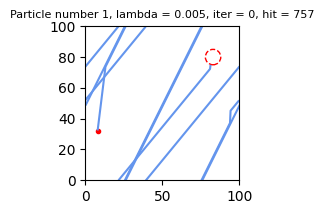

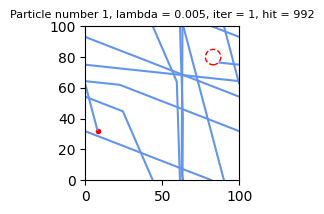

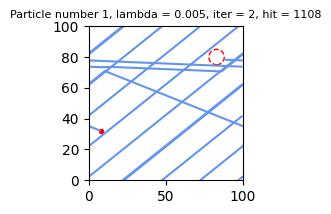

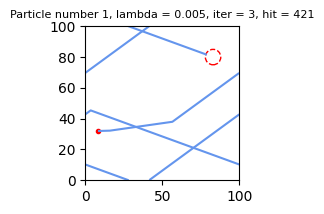

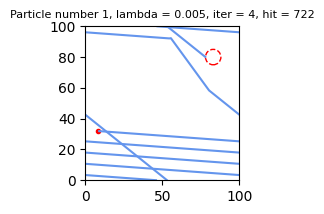

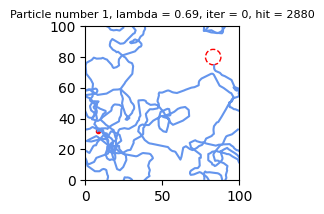

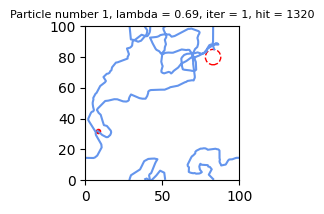

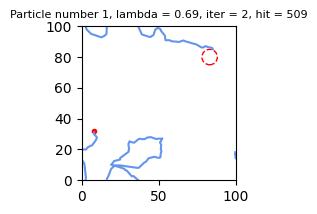

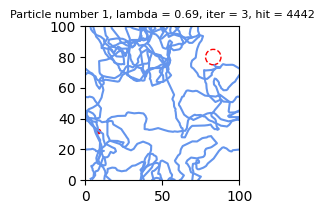

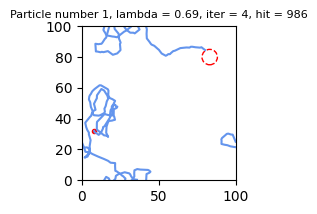

In [270]:
particles_for_viz = [1]
visualize_particles(
    lambda_values, iterations, particles_for_viz, x0, y0, 
    target_center, R, DL, root_dir,
)

In [284]:
hitting_times = record_hitting_times(lambda_values, iterations, hitting_times_directory, root_dir)

In [285]:
hitting_times = retrieve_hitting_times(hitting_times_directory)

Goodness-of-Fit Tests for lambda = 0.0, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0870, p-value = 0.4244
Goodness-of-Fit Tests for lambda = 0.0, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0925, p-value = 0.3677
Goodness-of-Fit Tests for lambda = 0.0, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0965, p-value = 0.3015
Goodness-of-Fit Tests for lambda = 0.0, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.1070, p-value = 0.1879
Goodness-of-Fit Tests for lambda = 0.0, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.0661, p-value = 0.7606
Mean Gamma Means value = 870.7424081632653
Mean Gamma Modes value = 59.60983661681189


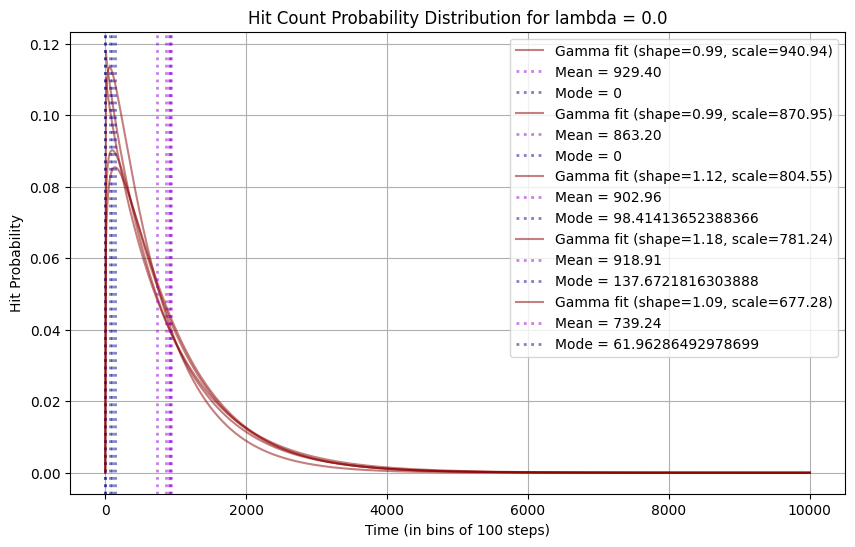

Goodness-of-Fit Tests for lambda = 0.001, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0665, p-value = 0.7430
Goodness-of-Fit Tests for lambda = 0.001, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0656, p-value = 0.7574
Goodness-of-Fit Tests for lambda = 0.001, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0774, p-value = 0.5606
Goodness-of-Fit Tests for lambda = 0.001, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.0616, p-value = 0.8198
Goodness-of-Fit Tests for lambda = 0.001, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.1047, p-value = 0.2082
Mean Gamma Means value = 853.1619999999999
Mean Gamma Modes value = 114.2532626066724


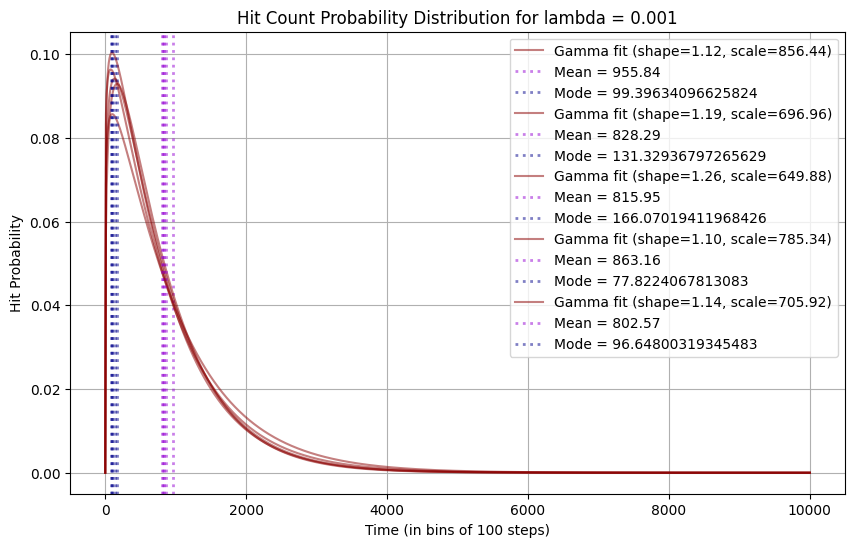

Goodness-of-Fit Tests for lambda = 0.005, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0636, p-value = 0.7888
Goodness-of-Fit Tests for lambda = 0.005, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0703, p-value = 0.6789
Goodness-of-Fit Tests for lambda = 0.005, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0444, p-value = 0.9843
Goodness-of-Fit Tests for lambda = 0.005, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.0527, p-value = 0.9302
Goodness-of-Fit Tests for lambda = 0.005, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.0512, p-value = 0.9438
Mean Gamma Means value = 957.094
Mean Gamma Modes value = 179.1579053098166


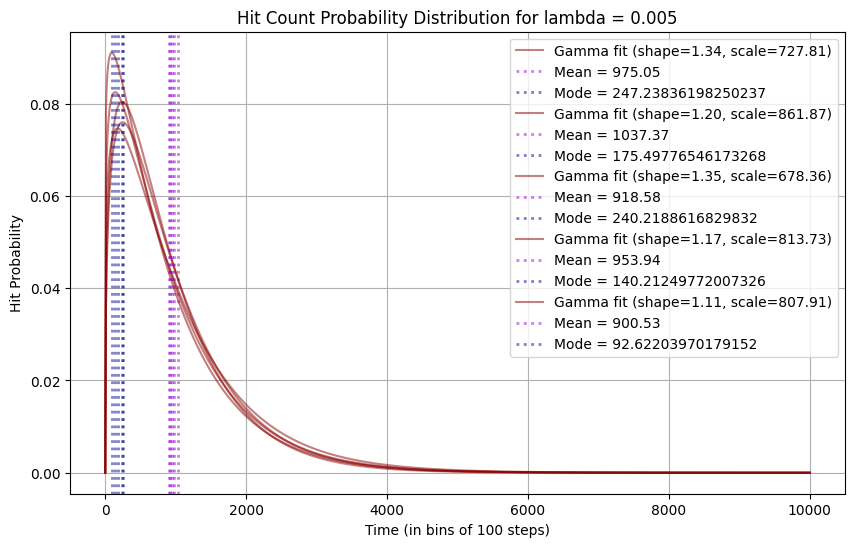

Goodness-of-Fit Tests for lambda = 0.01, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0467, p-value = 0.9741
Goodness-of-Fit Tests for lambda = 0.01, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0684, p-value = 0.7114
Goodness-of-Fit Tests for lambda = 0.01, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0646, p-value = 0.7735
Goodness-of-Fit Tests for lambda = 0.01, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.1129, p-value = 0.1444
Goodness-of-Fit Tests for lambda = 0.01, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.0562, p-value = 0.8927
Mean Gamma Means value = 945.778
Mean Gamma Modes value = 150.1945397533319


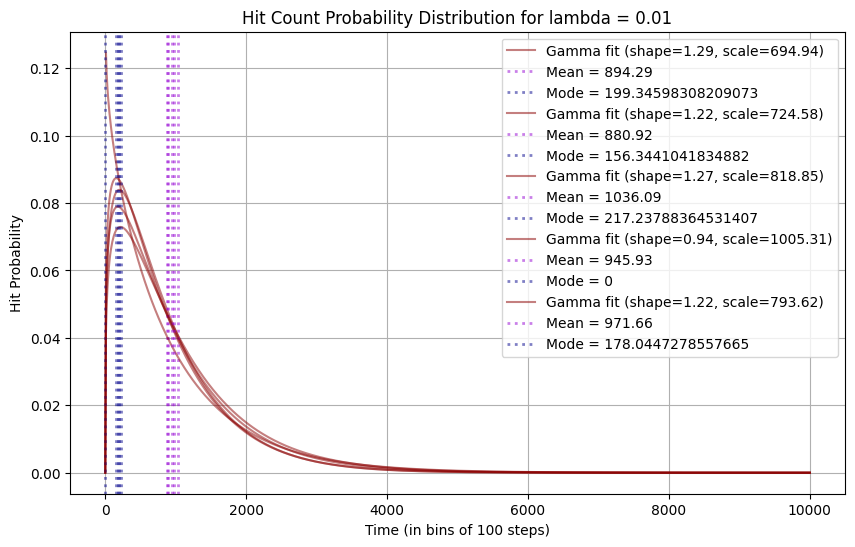

Goodness-of-Fit Tests for lambda = 0.03, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0488, p-value = 0.9616
Goodness-of-Fit Tests for lambda = 0.03, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0583, p-value = 0.8656
Goodness-of-Fit Tests for lambda = 0.03, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0727, p-value = 0.6399
Goodness-of-Fit Tests for lambda = 0.03, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.0611, p-value = 0.8274
Goodness-of-Fit Tests for lambda = 0.03, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.0605, p-value = 0.8357
Mean Gamma Means value = 997.344
Mean Gamma Modes value = 160.06902175477913


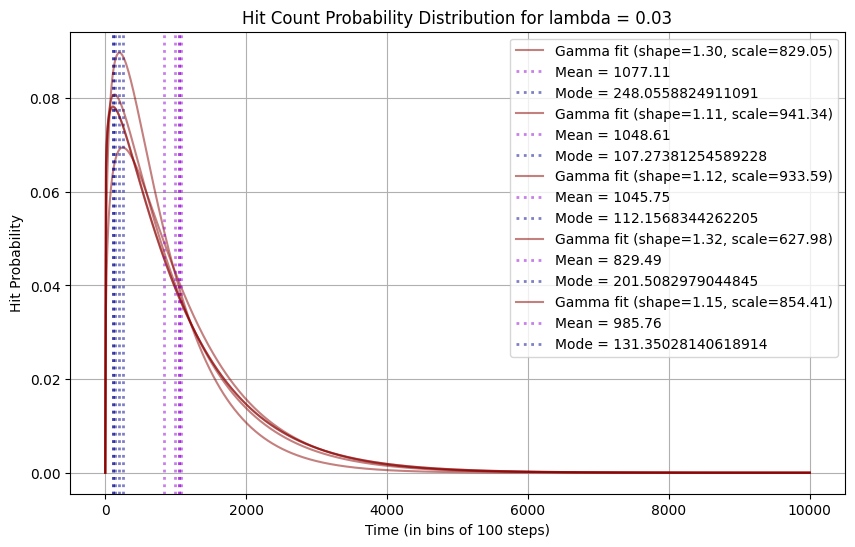

Goodness-of-Fit Tests for lambda = 0.05, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0698, p-value = 0.6876
Goodness-of-Fit Tests for lambda = 0.05, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0678, p-value = 0.7208
Goodness-of-Fit Tests for lambda = 0.05, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0979, p-value = 0.2748
Goodness-of-Fit Tests for lambda = 0.05, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.0600, p-value = 0.8429
Goodness-of-Fit Tests for lambda = 0.05, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.0936, p-value = 0.3247
Mean Gamma Means value = 1053.3980000000001
Mean Gamma Modes value = 96.2273436776354


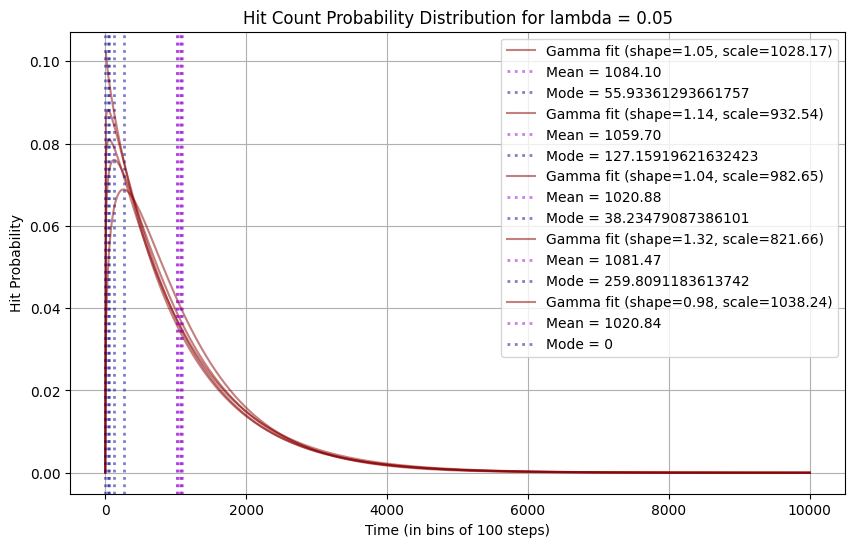

Goodness-of-Fit Tests for lambda = 0.1, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0638, p-value = 0.7867
Goodness-of-Fit Tests for lambda = 0.1, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0735, p-value = 0.6255
Goodness-of-Fit Tests for lambda = 0.1, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0655, p-value = 0.7596
Goodness-of-Fit Tests for lambda = 0.1, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.0569, p-value = 0.8838
Goodness-of-Fit Tests for lambda = 0.1, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.0744, p-value = 0.6105
Mean Gamma Means value = 1010.442
Mean Gamma Modes value = 150.71970404864098


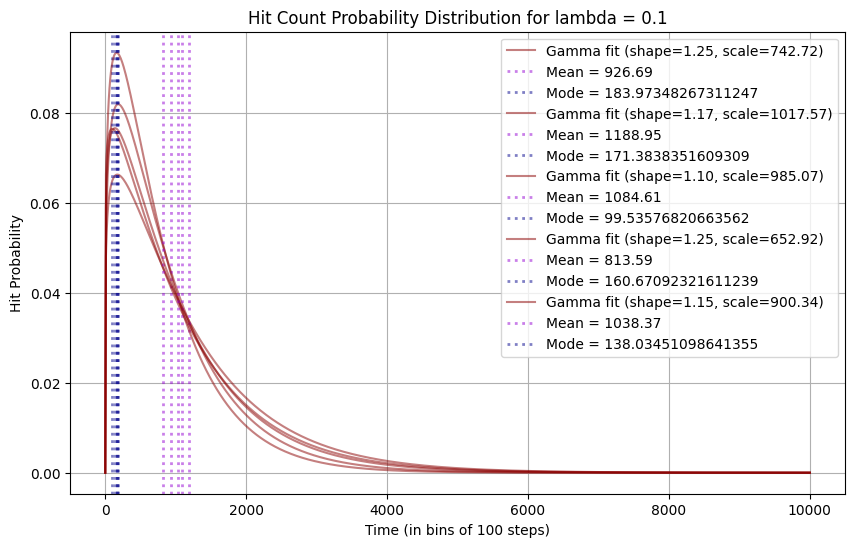

Goodness-of-Fit Tests for lambda = 0.3, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0764, p-value = 0.5762
Goodness-of-Fit Tests for lambda = 0.3, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0559, p-value = 0.8958
Goodness-of-Fit Tests for lambda = 0.3, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0733, p-value = 0.6285
Goodness-of-Fit Tests for lambda = 0.3, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.0798, p-value = 0.5214
Goodness-of-Fit Tests for lambda = 0.3, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.0692, p-value = 0.6979
Mean Gamma Means value = 1319.728
Mean Gamma Modes value = 248.81227118761012


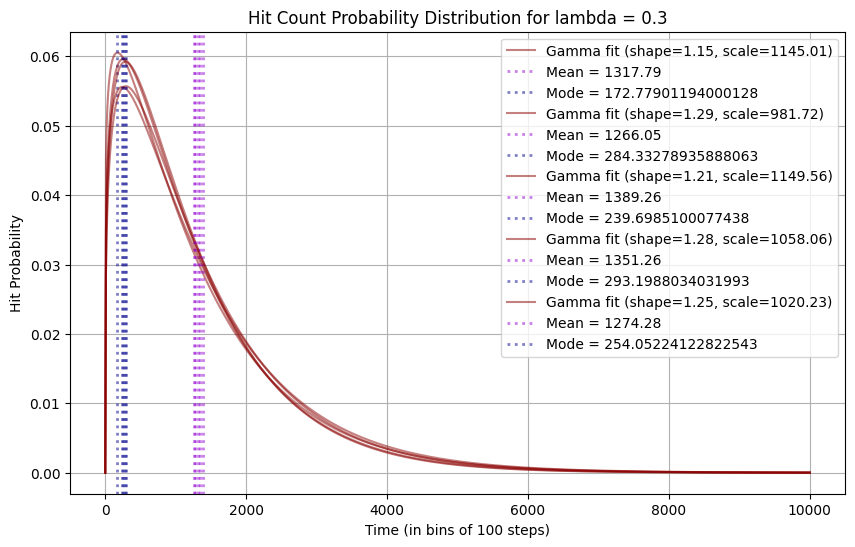

Goodness-of-Fit Tests for lambda = 0.5, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0597, p-value = 0.8476
Goodness-of-Fit Tests for lambda = 0.5, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0710, p-value = 0.6680
Goodness-of-Fit Tests for lambda = 0.5, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0446, p-value = 0.9844
Goodness-of-Fit Tests for lambda = 0.5, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.0627, p-value = 0.8084
Goodness-of-Fit Tests for lambda = 0.5, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.0792, p-value = 0.5314
Mean Gamma Means value = 1755.4403434343433
Mean Gamma Modes value = 380.11583762848966


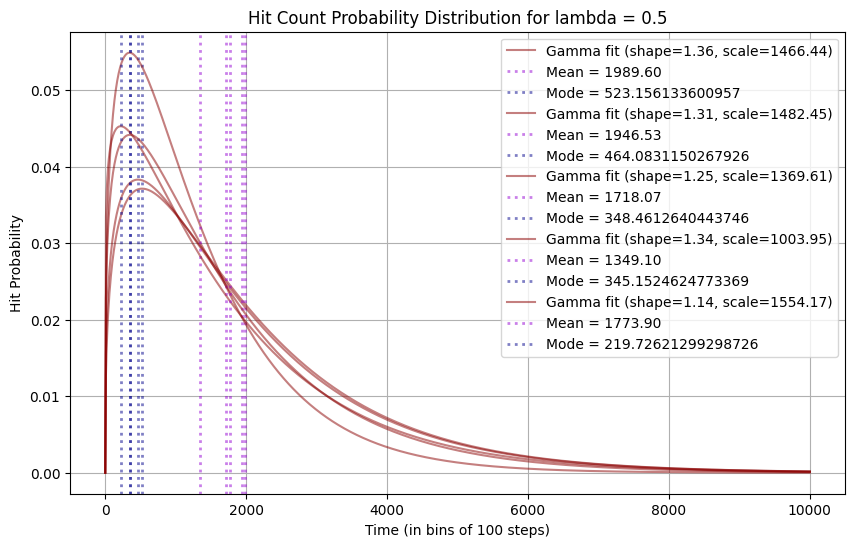

Goodness-of-Fit Tests for lambda = 0.69, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0708, p-value = 0.6714
Goodness-of-Fit Tests for lambda = 0.69, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0590, p-value = 0.8567
Goodness-of-Fit Tests for lambda = 0.69, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0818, p-value = 0.4965
Goodness-of-Fit Tests for lambda = 0.69, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.1012, p-value = 0.2556
Goodness-of-Fit Tests for lambda = 0.69, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.0756, p-value = 0.6032
Mean Gamma Means value = 2104.705218624282
Mean Gamma Modes value = 583.3511670603674


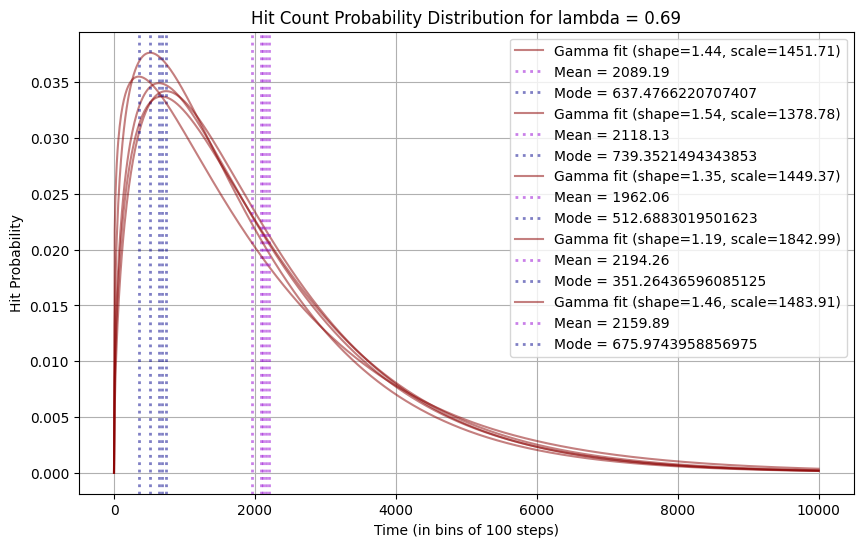

Goodness-of-Fit Tests for lambda = 1, iter = 0
Kolmogorov-Smirnov test: KS statistic = 0.0539, p-value = 0.9363
Goodness-of-Fit Tests for lambda = 1, iter = 1
Kolmogorov-Smirnov test: KS statistic = 0.0720, p-value = 0.7234
Goodness-of-Fit Tests for lambda = 1, iter = 2
Kolmogorov-Smirnov test: KS statistic = 0.0514, p-value = 0.9578
Goodness-of-Fit Tests for lambda = 1, iter = 3
Kolmogorov-Smirnov test: KS statistic = 0.0640, p-value = 0.8121
Goodness-of-Fit Tests for lambda = 1, iter = 4
Kolmogorov-Smirnov test: KS statistic = 0.1023, p-value = 0.2769
Mean Gamma Means value = 3147.8626399114896
Mean Gamma Modes value = 1197.3694028806872


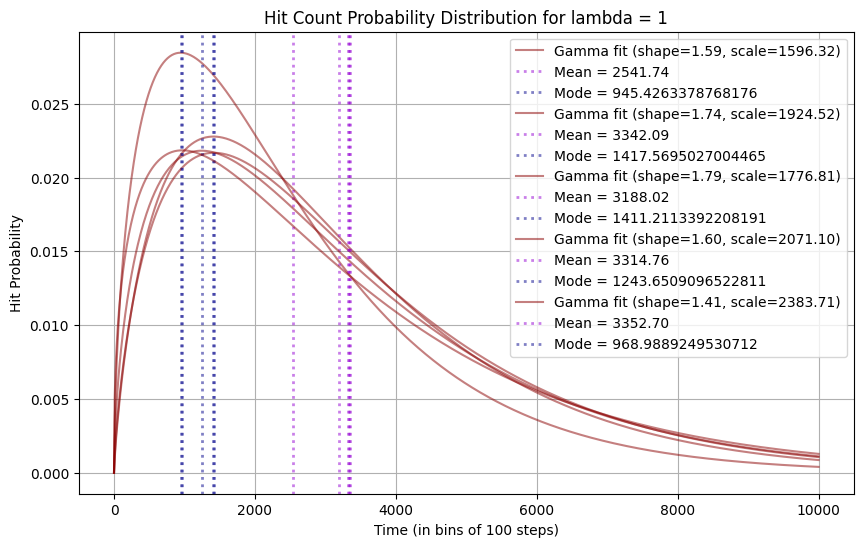

In [286]:
lambda_values = [0.0, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.69, 1]
plot_hit_probability_distributions(
    lambda_values, iterations, hitting_times, bin_size, Nmax, dt,
)

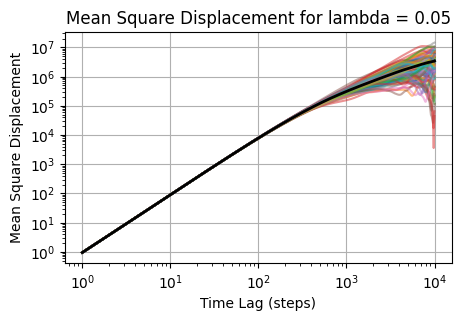

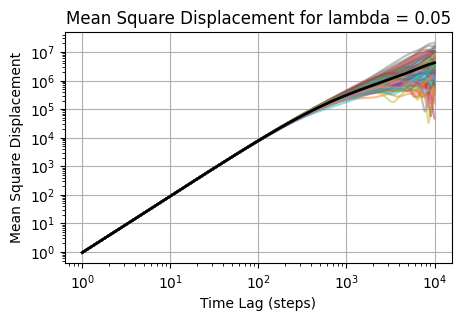

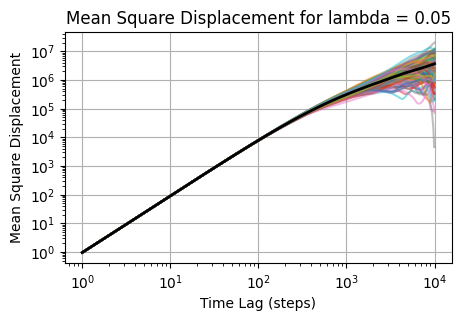

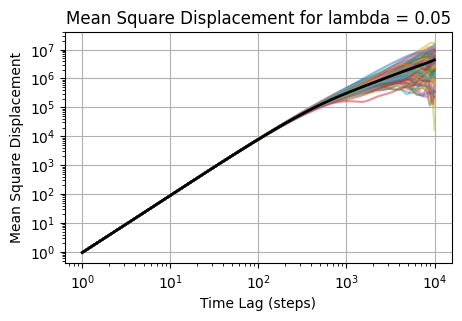

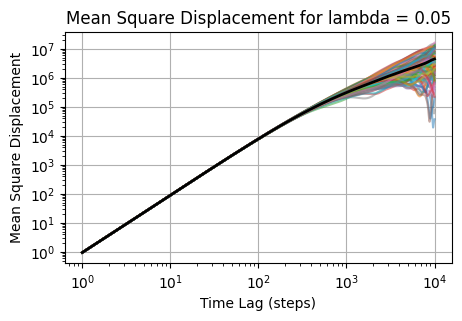

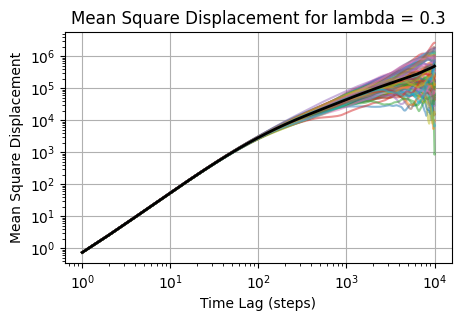

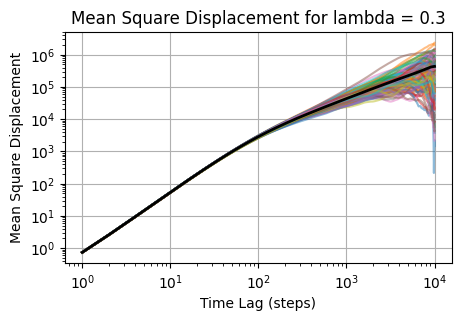

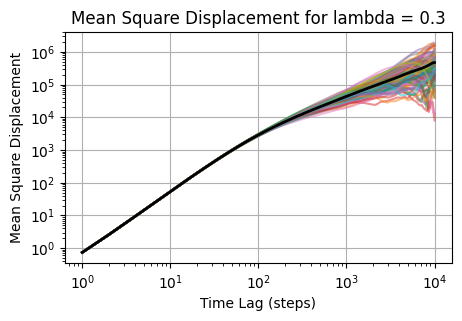

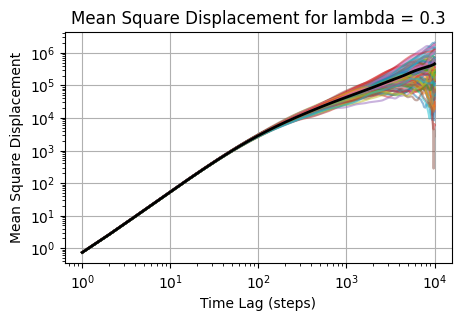

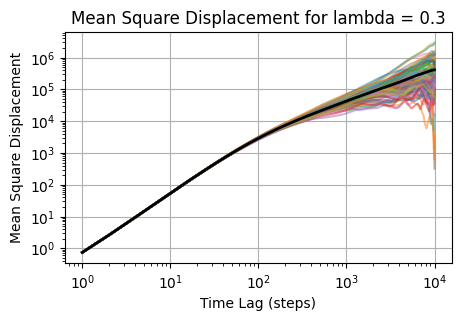

In [287]:
lambda_values = [0.05, 0.3]
compute_and_plot_msds(lambda_values, iterations, msd_directory, root_dir)

In [288]:
mean_msds = []
lambda_values = [0.0, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.69, 1]

# Load mean msd data from JSON files
for lambda_val, iter in product(lambda_values, range(iterations)):
        mean_msd_filename = f'./{msd_directory}/mean_msd_{lambda_val}_{iter}.json'
        with open(mean_msd_filename, 'r') as file:
            mean_msd_data = json.load(file)
            mean_msd_array = np.array(mean_msd_data)  # Convert list back to numpy array
            mean_msds.append(mean_msd_data)

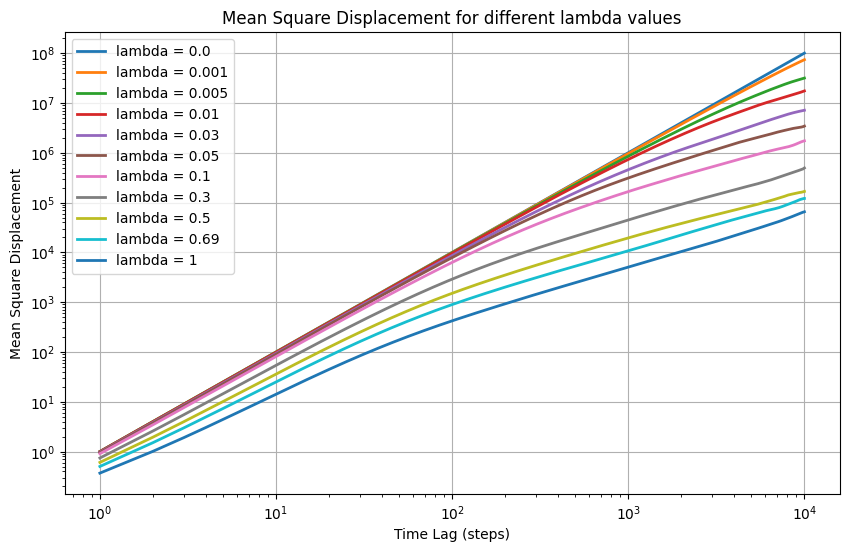

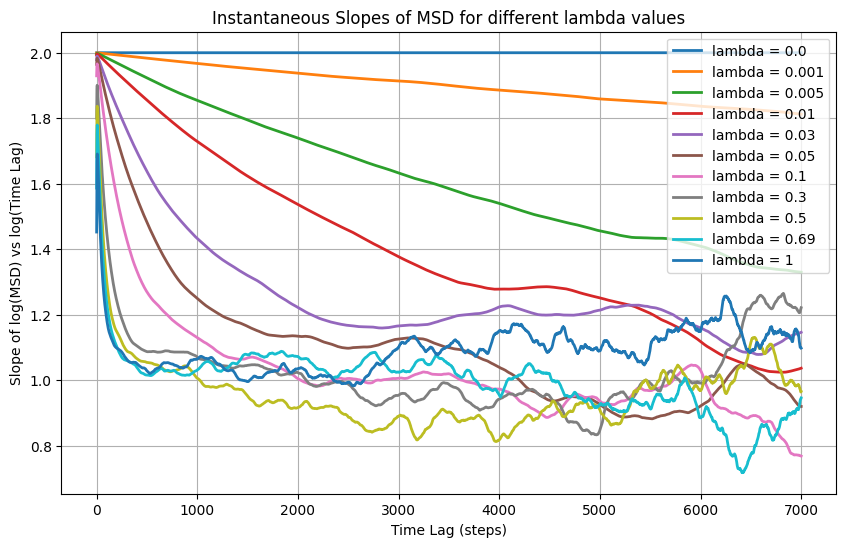

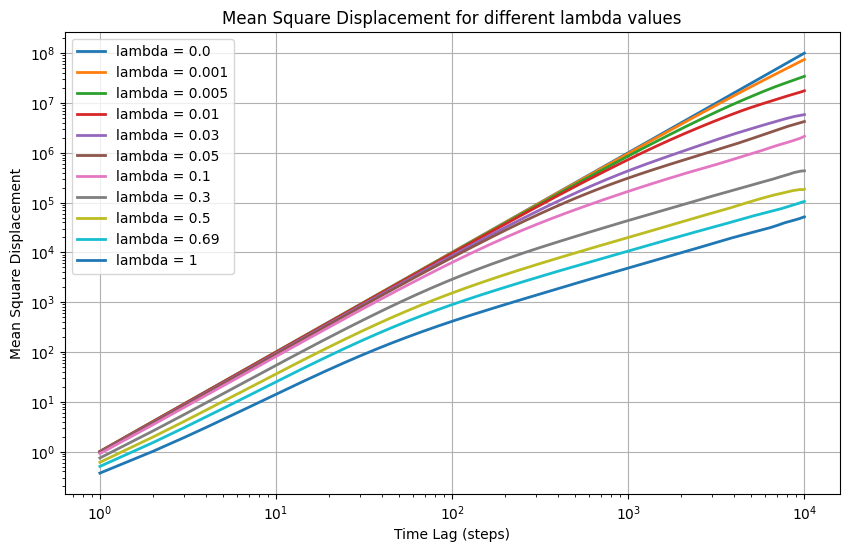

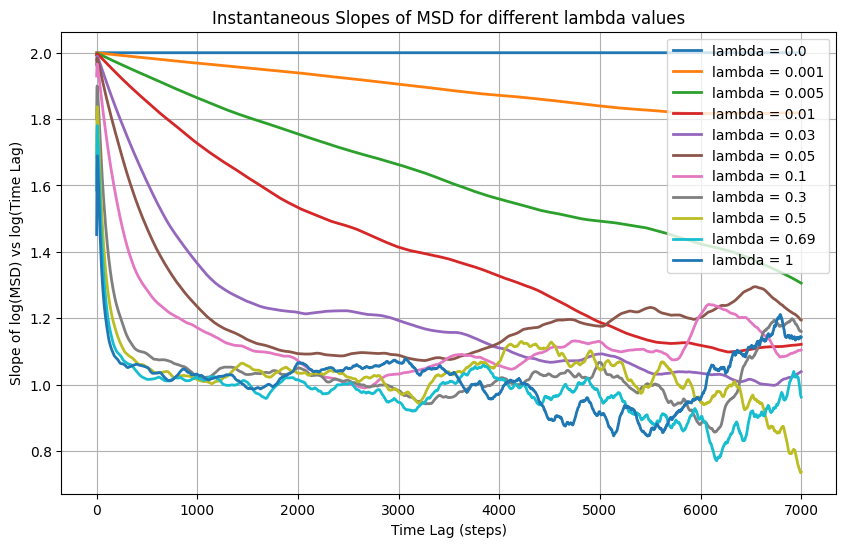

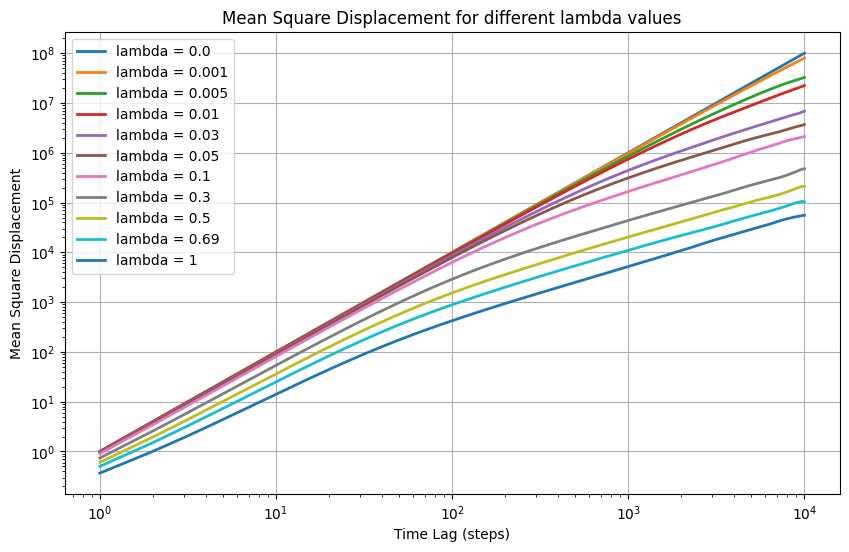

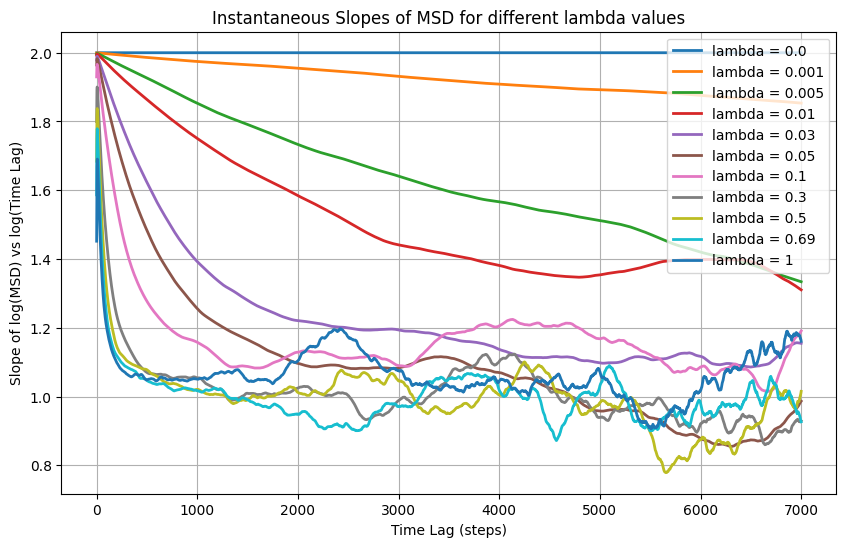

In [290]:
plot_msd_and_slopes(lambda_values, mean_msds[::iterations], range(1, Nmax), 7000)
plot_msd_and_slopes(lambda_values, mean_msds[1::iterations], range(1, Nmax), 7000)
plot_msd_and_slopes(lambda_values, mean_msds[2::iterations], range(1, Nmax), 7000)